In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
import matplotlib.colors as mcolors

# plotting parameters
geophones = ['00368', '00380', '00400']
colors = ['#66c2a5','#fc8d62','#8da0cb']
colormaps = [mcolors.LinearSegmentedColormap.from_list("my_custom_map", ['white', color]) for color in colors]
markers = ['.', '^', 'x']

In [27]:
from matplotlib.patches import Ellipse, Rectangle
def plot_ellipse(ax, xy, cov, **kwargs):
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)

    nconf = 2
    angle = np.rad2deg(np.arctan2(*v[:, np.argmax(abs(lambda_))][::-1]))
    width = lambda_[np.argmax(abs(lambda_))] * nconf * 2
    height = lambda_[1 - np.argmax(abs(lambda_))] * nconf * 2

    ell = Ellipse(xy=xy,
                  width=width, height=height,
                  angle=angle,
                  **kwargs)
    ax.add_artist(ell)


def annotate_axs(axs, x=0.01, y=0.99):
    letters = 'abcdefghijklmnopqrstuvwxyz'

    if x <= 0.5:
        ha = 'left'
    else:
        ha = 'right'

    if y <= 0.5:
        va = 'bottom'
    else:
        va = 'top'

    for i, ax in enumerate(axs.flatten()):
        ax.text(x, y, f'{letters[i]})', ha=ha, va=va, transform=ax.transAxes)

Let's import the dataframe used for the entirety of the data. This data is already log transformed.

In [3]:
Xdf = pd.read_csv('../classified_signals_pca_features.csv', delimiter=';')
Xdf.index = pd.to_datetime(Xdf['DATE'])
Xdf = Xdf.drop(['DATE', 'LABEL'], axis=1)

In [6]:
Xdf = (Xdf - Xdf.mean())/Xdf.std()
from sklearn.decomposition import PCA
pca = PCA()
X = pca.fit_transform(Xdf)

(-10.0, 25.0)

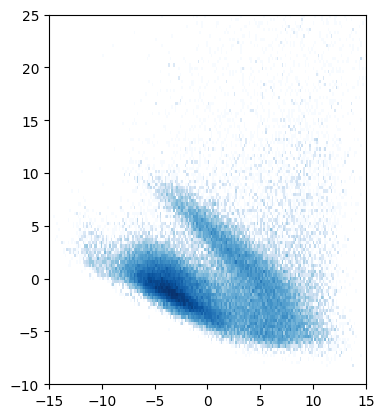

In [16]:
# since there are a lot of points, a 2d histogram better shows the density
from matplotlib.colors import LogNorm

plt.hist2d(X[:, 0], X[:, 1], 300, cmap='Blues', norm=LogNorm())
plt.gca().set_aspect(1)
plt.xlim(-15, 15)
plt.ylim(-10, 25)

We can try the Gaussian Mixture clustering as is done in the paper, but any clustering algorithm from ``scikit-learn`` can be easily integrated into this workflow.

In [31]:
from sklearn.mixture import GaussianMixture
ncomponents = 25
nclusters = 3
np.random.seed(42069)
clf = GaussianMixture(n_components=nclusters)
labels = clf.fit_predict(X[:, :ncomponents])
labels = np.where(labels == 1, 2, np.where(labels == 2, 1, labels))

You'll notice that I switch the labels 1 and 2, this is done because I got used to calling the clusters in a certain order. Depending on the random seed, the labels (0, 1 or 2) from the GMM might not always be in the same order.

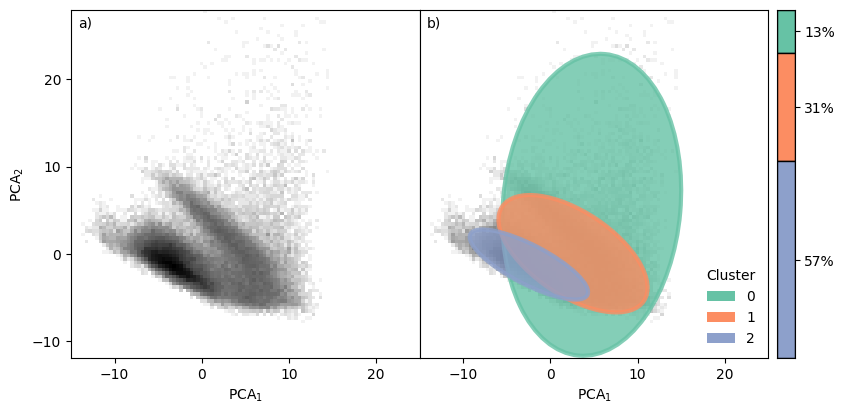

In [33]:
%matplotlib inline
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
fig, axs = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(9, 5))

xlim = [-15, 25]
ylim = [-12, 28]

axs[0].hist2d(X[:, 0], X[:, 1], 100, range=[xlim, ylim], norm=LogNorm(), cmap='Greys')
axs[1].hist2d(X[:, 0], X[:, 1], 100, range=[xlim, ylim], norm=LogNorm(), cmap='Greys', zorder=0)

patches = []
counts = np.zeros(clf.n_components)

covsize = np.prod(clf.covariances_[:, :2, :2][:, [0, 1], [0, 1]], axis=-1)
covorder = covsize.argsort().argsort()

for c in range(clf.n_components):
    cc = labels == c
    counts[c] = cc.sum()

    x, y = X[cc, :2].T
    
    xy = clf.means_[[0, 2, 1][c], :2]
    cov = clf.covariances_[[0, 2, 1][c], :2, :2]

    plot_ellipse(ax=axs[1], xy=(xy), cov=cov, fc=colors[c], ec=colors[c], lw=3, alpha=0.8, zorder=1 + nclusters - covorder[[0, 2, 1][c]])
    patches.append(Rectangle([0, 0], 1, 1, lw=0, fc=colors[c], label=c))

axs[0].set_aspect(1)
axs[1].set_aspect(1)
axs[1].set_xlim(*xlim)
axs[1].set_ylim(*ylim)

axs[0].yaxis.set_major_locator(plt.MaxNLocator(4))
axs[0].xaxis.set_major_locator(plt.MaxNLocator(4))

axs[0].set_ylabel('PCA$_2$')
axs[0].set_xlabel('PCA$_1$')
axs[1].set_xlabel('PCA$_1$')
axs[1].legend(handles=patches,  loc='lower right', frameon=False, title='Cluster', ncol=1)
axs[1].tick_params('y', length=0)
fig.subplots_adjust(wspace=0.0)

bbox = axs[1].get_position()
ax3 = fig.add_axes([bbox.x1 + 0.025 * (bbox.x1 - bbox.x0), bbox.y0, 0.05 * (bbox.x1 - bbox.x0), bbox.y1 - bbox.y0])
ax3.yaxis.tick_right()
ax3.set_xticks([])
for c in range(clf.n_components):
    ax3.bar(0, counts[c], width=1, bottom=0 if c == 0 else counts[:c].sum(), fc=colors[c], ec='k')
ax3.set_ylim(0, counts.sum())
ax3.set_xlim(-0.5, 0.5)
ax3.set_yticks(counts.cumsum() - counts/2)
ax3.set_yticklabels([f'{100 * i:.0f}%'.zfill(3) for i in counts/counts.sum()])
ax3.invert_yaxis()

annotate_axs(axs, x=0.02, y=0.98)

fig.patch.set_facecolor('none')

We are interested in tracking the rate of occurrence of every cluster. We can use ``pandas`` for that.

grouper = pd.Grouper()